In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_filtered = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

In [ ]:
missing_counts = df_filtered.isna().groupby(df_filtered['location']).sum().sum(axis=1)

In [ ]:
missing_counts.sort_values()

,0
location,
Czechia,24759
Italy,26030
Malaysia,26252
Canada,32340
South Africa,32865
Chile,34362
Australia,39105


In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.sort_values('date')

#Set Generation interval (e.g. 5 days)
tau = 5

#shift new cases by tau days to estimate Rt
df_filtered['shifted_cases']= df_filtered['new_cases'].shift(tau)

#Calculate Rt.
df_filtered['reproduction_rate'] = df_filtered['new_cases'] / df_filtered['shifted_cases']

df_filtered['reproduction_rate_smoothed'] = df_filtered['reproduction_rate'].rolling(window=7).mean()

#View the result
print(df_filtered[['date', 'new_cases', 'reproduction_rate', 'reproduction_rate_smoothed']].dropna())

            date  new_cases  reproduction_rate  reproduction_rate_smoothed
64    2020-03-09        0.0                0.0                   13.203782
3429  2020-03-16        0.0                0.0                    0.812540
10143 2020-03-23        0.0                0.0                    0.034366
85    2020-03-30        0.0                0.0                    0.208908
6809  2020-04-06        0.0                0.0                    0.284736
...          ...        ...                ...                         ...
9960  2024-04-22        0.0                0.0                   52.761279
8293  2024-04-29        0.0                0.0                    0.032685
4941  2024-05-06        0.0                0.0                    4.462695
3264  2024-05-13        0.0                0.0                  322.531520
11662 2024-05-20        0.0                0.0                    0.002652

[177 rows x 4 columns]


In [ ]:
df_filtered.to_excel('owid-covid-data_Filtered-mod.xlsx')

In [ ]:
import pandas as pd

#Load Excel Data
df_reproduction_rate = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')
df_reproduction_rate['new_cases'] = df_reproduction_rate['new_cases'].fillna(0) # Fill missing with 0 or use interpolation



In [ ]:
import numpy as np
from scipy.stats import gamma

# Shows the difference between the time an infector shows symptoms and the onset of symptoms in the person they infected.
def discretized_serial_interval(mean_si=5, std_si=2, max_days=15):
  shape = (mean_si/std_si)**2
  scale = (std_si**2)/mean_si
  days = np.arange(1, max_days + 1)
  probs = gamma.pdf(days, a=shape, scale=scale)
  return probs/probs.sum()

In [ ]:
def estimate_Rt(incidence, si_weights):
  Rt_values = [np.nan] * len(incidence)
  max_lag = len(si_weights)

  for t in range (max_lag, len(incidence)):
    past_infectivity = 0
    for tau in range (1, max_lag + 1):
      past_infectivity += incidence[t - tau] * si_weights[tau - 1]
    if past_infectivity > 0:
      Rt_values[t]= incidence[t]/past_infectivity
    else:
      Rt_values[t] = np.nan
  return Rt_values

In [ ]:
incidence = df_reproduction_rate['new_cases'].values

si_weights = discretized_serial_interval()

df_reproduction_rate['reproduction_rate'] = estimate_Rt(incidence, si_weights)

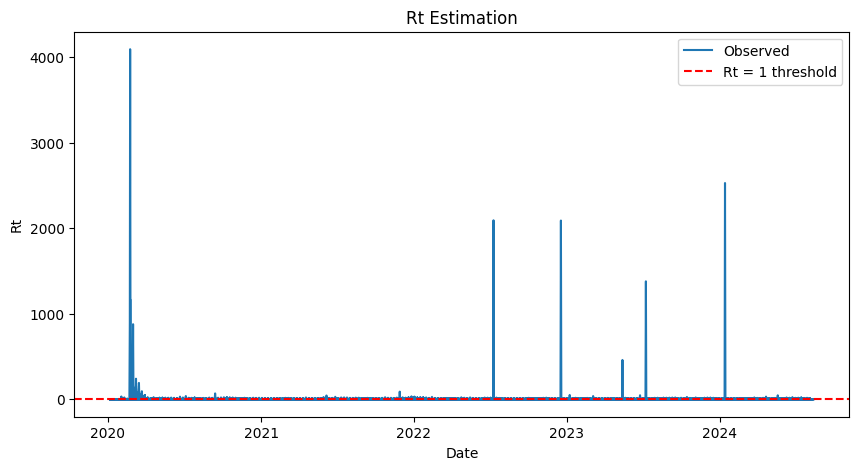

In [ ]:
df_reproduction_rate.to_excel('with_Rt_output.xlsx', index = False)

#Optional : Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_reproduction_rate['date'], df_reproduction_rate['reproduction_rate'], label='Observed')
plt.axhline(y=1, color='red', linestyle='--', label='Rt = 1 threshold')
plt.xlabel('Date')
plt.ylabel('Rt')
plt.title('Rt Estimation')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)

In [ ]:
missing_counts

,0
location,
Australia,39105
Canada,32340
Chile,34362
Czechia,24759
Italy,26030
Malaysia,26252
South Africa,32865


In [ ]:
missing_counts.sort_values()

,0
location,
Czechia,24759
Italy,26030
Malaysia,26252
Canada,32340
South Africa,32865
Chile,34362
Australia,39105


   new_cases  hosp_patients  hosp_patients_per_million  \
0        0.0            NaN                        NaN   
1        0.0            NaN                        NaN   
2        0.0            NaN                        NaN   
3        0.0            NaN                        NaN   
4        0.0            NaN                        NaN   

   weekly_hosp_admissions  reproduction_rate  
0                     NaN                NaN  
1                     NaN                NaN  
2                     NaN                NaN  
3                     NaN                NaN  
4                     NaN                NaN  
R² Score: 0.4697337781322778
y_test shape: (2348,)
y_pred shape: (2348,)


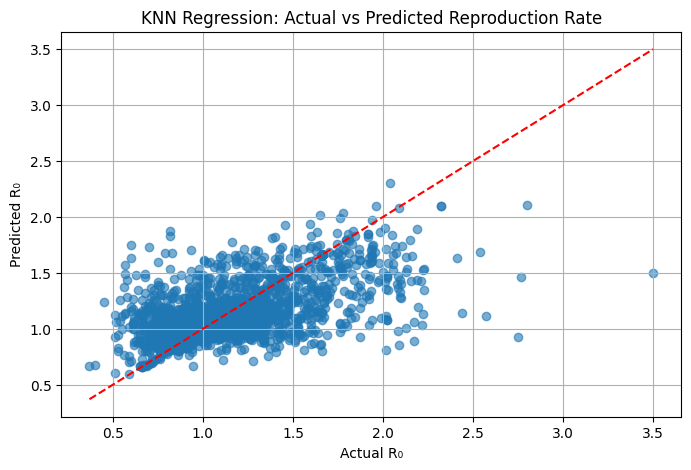

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1. Load your dataset
# -----------------------------------------------
# Replace with your actual data source
df = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

# Example: Preview data
print(df[["new_cases", "hosp_patients", "hosp_patients_per_million",
          "weekly_hosp_admissions", "reproduction_rate"]].head())

# -----------------------------------------------
# 2. Select Features & Target
# -----------------------------------------------
features = ["new_cases", "hosp_patients", "hosp_patients_per_million", "weekly_hosp_admissions"]
target = "reproduction_rate"

# Subset the data
data = df[features + [target]]

# -----------------------------------------------
# 3. Impute Missing Values (KNNImputer)
# -----------------------------------------------
# KNNImputer fills missing values using similar rows (neighbors)
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# -----------------------------------------------
# 4. Normalize Features
# -----------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(data_imputed[features])
y = data_imputed[target]

# -----------------------------------------------
# 5. Train/Test Split
# -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------
# 6. Train KNN Regressor
# -----------------------------------------------
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# -----------------------------------------------
# 7. Evaluation
# -----------------------------------------------
print("R² Score:", r2_score(y_test, y_pred))
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

# -----------------------------------------------
# 8. Optional: Plot Actual vs Predicted
# -----------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual R₀")
plt.ylabel("Predicted R₀")
plt.title("KNN Regression: Actual vs Predicted Reproduction Rate")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Reset index before splitting
data_imputed = data_imputed.reset_index(drop=True)

# Split again with return_index=True
from sklearn.model_selection import train_test_split
X = data_imputed[features]
y = data_imputed["reproduction_rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get indices of test set
test_indices = X_test.index

# Add predictions back
data_imputed.loc[test_indices, "predicted_R0"] = y_pred


In [ ]:
# OR: Save the full imputed dataset with predictions
data_imputed.to_excel("predicted_R0_full_dataset.xlsx", index=False)


In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load your Excel file
df = pd.read_excel("/content/owid-covid-data_latest_update.xlsx")

# Columns to use for imputation (adjusted for usefulness and availability)
features = [
    'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
    'total_cases_per_million', 'new_cases_per_million',
    'hosp_patients', 'hosp_patients_per_million', 'weekly_hosp_admissions',
    'weekly_hosp_admissions_per_million', 'stringency_index',
    'population_density', 'median_age', 'gdp_per_capita',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index', 'population',
    'reproduction_rate', 'icu_patients_per_million'
]

# Subset and apply imputer
df_impute = df[features].copy()
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_impute)

# Replace only the missing values
df_imputed = pd.DataFrame(imputed, columns=features)
df['icu_patients_per_million'] = df['icu_patients_per_million'].combine_first(df_imputed['icu_patients_per_million'])

# Save to Excel
df.to_excel("owid-covid-data_with_latest_update.xlsx", index=False)
print("✅ Saved to 'owid-covid-data_with_latest_update.xlsx'")


FileNotFoundError: [Errno 2] No such file or directory: '/content/owid-covid-data_latest_update.xlsx'

In [ ]:
import matplotlib.pyplot as plt

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']

plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients_per_million'], color ='Yellow', label='South Africa')
plt.plot(df_Malaysia['date'], df_Malaysia['icu_patients_per_million'], color ='Green', label='Malaysia')
plt.plot(df_Czechia['date'], df_Czechia['icu_patients_per_million'], color ='Blue', label='Czechia')
plt.plot(df_Australia['date'], df_Australia['icu_patients_per_million'], color ='Red', label='Australia')
plt.plot(df_Canada['date'], df_Canada['icu_patients_per_million'], color ='Black', label='Canada')
plt.plot(df_Chile['date'], df_Chile['icu_patients_per_million'], color = 'orange', label='Chile')

plt.xlabel('Date')
plt.ylabel('ICU Patients per Million')
plt.title('ICU Patients per Million over Time by Location')
plt.legend()
plt.show()

In [ ]:
missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients'])

In [ ]:
import matplotlib.pyplot as plt

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']

plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients'], color ='Yellow', label='South Africa')
plt.plot(df_Malaysia['date'], df_Malaysia['icu_patients'], color ='Green', label='Malaysia')
plt.plot(df_Czechia['date'], df_Czechia['icu_patients'], color ='Blue', label='Czechia')
plt.plot(df_Australia['date'], df_Australia['icu_patients'], color ='Red', label='Australia')
plt.plot(df_Canada['date'], df_Canada['icu_patients'], color ='Black', label='Canada')
plt.plot(df_Chile['date'], df_Chile['icu_patients'], color = 'orange', label='Chile')

plt.xlabel('Date')
plt.ylabel('ICU Patients per Million')
plt.title('ICU Patients per Million over Time by Location')
plt.legend()
plt.show()

In [ ]:
# Impute ICU patients in the dataset
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.impute import KNNImputer # Import KNNImputer

# Load the dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# Drop non-numeric columns
df = df.select_dtypes(include=['number'])

# Choose features that may help predict ICU admissions
features = [
    'new_cases', 'new_deaths', 'hosp_patients', 'weekly_hosp_admissions',
    'reproduction_rate', 'stringency_index', 'population', 'population_density',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'median_age', 'gdp_per_capita'
]

# Keep only available columns
features = [col for col in features if col in df.columns and col != 'icu_patients']

# Split rows with and without ICU data
df_known = df[df['icu_patients'].notna()].copy()
df_missing = df[df['icu_patients'].isna()].copy()

# Remove rows with missing values in features for training
df_known = df_known.dropna(subset=features)

#Train regression model
X_train = df_known[features]
y_train = df_known['icu_patients']
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate performance
X_test = df_known[features]
y_test = df_known['icu_patients']
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"✅ Model trained. RMSE on known data: {rmse:.2f} ICU patients")

#Predict and impute missing ICU values in df_missing
X_missing = df_missing[features]

# Impute missing values in X_missing
imputer = KNNImputer(n_neighbors=5)
X_missing_imputed = imputer.fit_transform(X_missing)
X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=features, index=X_missing.index)


# Predict on the imputed missing data
predicted_icu = model.predict(X_missing_imputed_df)

# Impute the 'icu_patients' column in the original DataFrame
df.loc[df['icu_patients'].isna(), 'icu_patients'] = predicted_icu


# Save to Excel
df.to_excel("owid-covid-data_with_icu_imputed.xlsx", index=False)
print("✅ File saved as 'owid-covid-data_with_icu_imputed.xlsx'")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 1. Drop all string and datetime columns to retain only usable numeric features
df_numeric = df.select_dtypes(include=[np.number]).copy()

# 2. Identify rows with and without ICU patient values
df_with_icu = df_numeric[df_numeric['icu_patients'].notna()]
df_missing_icu = df_numeric[df_numeric['icu_patients'].isna()]

# 3. Select features (exclude target column)
features = df_numeric.columns.drop('icu_patients')

# 4. Impute missing feature values
imputer = SimpleImputer(strategy="mean")
X_full = imputer.fit_transform(df_with_icu[features])
y_full = df_with_icu['icu_patients']

# 5. Train a fast, accurate model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_full, y_full)

# 6. Predict missing ICU patients
X_missing = imputer.transform(df_missing_icu[features])
icu_predicted = model.predict(X_missing)

# 7. Ensure predictions are non-negative integers
icu_predicted = np.maximum(icu_predicted, 0)  # eliminate negatives
icu_predicted = np.round(icu_predicted).astype(int)  # round to integers

# 8. Fill back into original dataframe
df.loc[df['icu_patients'].isna(), 'icu_patients'] = icu_predicted

# 9. Save to Excel
df.to_excel("owid-covid-data_with_icu_predictions.xlsx", index=False)
print("✅ Saved updated file: 'owid-covid-data_with_icu_predictions.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

# Load your dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 1. Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2. Add numeric date (for trend modeling)
df['date_ordinal'] = df['date'].map(datetime.toordinal)

# 3. Drop non-numeric columns except 'location' (we'll handle it separately)
keep_cols = df.select_dtypes(include=[np.number]).columns.tolist() + ['location']
df = df[keep_cols]

# 4. Track final predictions for merging
df['icu_predicted'] = df['icu_patients']

# 5. Prepare a loop per country
countries = df['location'].dropna().unique()

for country in countries:
    sub_df = df[df['location'] == country]

    # Must have some known ICU data to train
    if sub_df['icu_patients'].notna().sum() < 10:
        continue

    # Features (drop ICU, include date_ordinal)
    features = sub_df.columns.drop(['icu_patients', 'icu_predicted', 'location'])
    df_train = sub_df[sub_df['icu_patients'].notna()]
    df_missing = sub_df[sub_df['icu_patients'].isna()]

    if df_missing.empty:
        continue

    # Impute missing feature values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(df_train[features])
    y_train = df_train['icu_patients']
    X_missing = imputer.transform(df_missing[features])

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_missing)
    y_pred = np.maximum(y_pred, 0)  # No negatives
    y_pred = np.round(y_pred).astype(int)

    # Fill into main df
    df.loc[(df['location'] == country) & (df['icu_patients'].isna()), 'icu_predicted'] = y_pred

# 6. Replace original ICU column with predicted where missing
df['icu_patients'] = df['icu_patients'].combine_first(df['icu_predicted'])
df = df.drop(columns=['icu_predicted'])

# 7. Save to Excel
df.to_excel("owid-covid-data_with_icu_predictions_realistic.xlsx", index=False)
print("✅ Saved: 'owid-covid-data_with_icu_predictions_realistic.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 1. Load your dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 2. Convert 'date' column to datetime if needed
if df['date'].dtype == object:
    df['date'] = pd.to_datetime(df['date'])

# 3. Drop string-based columns (except 'location' and 'date')
exclude_types = ['object', 'string']
exclude_columns = df.select_dtypes(include=exclude_types).columns.difference(['location', 'date'])
df = df.drop(columns=exclude_columns)

# 4. Define features (all numeric columns except the target and 'location', 'date')
all_features = df.select_dtypes(include=[np.number]).columns.difference(['icu_patients'])
features = list(all_features)

# 5. Prepare final dataframe for imputation
df.sort_values(['location', 'date'], inplace=True)

# 6. Initialize model
model = HistGradientBoostingRegressor(random_state=42)

# 7. Predict ICU patients per country
df['icu_patients_predicted'] = df['icu_patients']  # start with original values

for country in df['location'].unique():
    sub = df[df['location'] == country].copy()

    # Only proceed if there are known values to train on
    known = sub[sub['icu_patients'].notna()]
    unknown = sub[sub['icu_patients'].isna()]

    if len(known) < 10 or len(unknown) == 0:
        continue  # skip countries with insufficient data

    X_train = known[features]
    y_train = known['icu_patients']
    X_pred = unknown[features]

    # Remove any rows with missing values in features
    X_train = X_train.dropna()
    y_train = y_train.loc[X_train.index]
    X_pred = X_pred.dropna()

    if X_train.empty or X_pred.empty:
        continue

    model.fit(X_train, y_train)
    y_pred = model.predict(X_pred)

    # Round, clip, and update predictions
    y_pred = np.round(np.clip(y_pred, 0, None)).astype(int)
    df.loc[X_pred.index, 'icu_patients_predicted'] = y_pred

# 8. Fill missing icu_patients
df['icu_patients'] = df['icu_patients'].combine_first(df['icu_patients_predicted'])

# 9. Drop helper column
df = df.drop(columns=['icu_patients_predicted'])

# 10. Save the final output
df.to_excel("owid-covid-data_with_icu_patients_imputed.xlsx", index=False)
print("✅ File saved: 'owid-covid-data_with_icu_patients_imputed.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

# Load the dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# Convert 'date' column to datetime
if df['date'].dtype == object:
    df['date'] = pd.to_datetime(df['date'])

# Drop string and object columns except 'location' and 'date'
drop_cols = df.select_dtypes(include=['object', 'string']).columns.difference(['location', 'date'])
df = df.drop(columns=drop_cols)

# Define features (all numeric except icu_patients and identifiers)
features = df.select_dtypes(include=[np.number]).columns.difference(['icu_patients']).tolist()

# Prepare for imputation
df = df.sort_values(['location', 'date'])
df['icu_patients_imputed'] = df['icu_patients']

# Initialize model
model = HistGradientBoostingRegressor(random_state=42)

# Track countries skipped
skipped_countries = []
successful_countries = []

# Iterate per country
for country in df['location'].unique():
    country_df = df[df['location'] == country].copy()

    known = country_df[country_df['icu_patients'].notna()]
    unknown = country_df[country_df['icu_patients'].isna()]

    if len(known) < 5 or len(unknown) == 0:
        skipped_countries.append(country)
        continue

    # Prepare training data
    X_train = known[features].dropna()
    y_train = known.loc[X_train.index, 'icu_patients']

    if X_train.empty:
        skipped_countries.append(country)
        continue

    # Train model
    model.fit(X_train, y_train)

    # Predict on unknown rows that have no NaNs
    X_pred = unknown[features].dropna()

    if X_pred.empty:
        skipped_countries.append(country)
        continue

    y_pred = model.predict(X_pred)
    y_pred = np.round(np.clip(y_pred, 0, None)).astype(int)

    # Impute values
    df.loc[X_pred.index, 'icu_patients_imputed'] = y_pred
    successful_countries.append(country)

# Finalize: replace original column
df['icu_patients'] = df['icu_patients'].combine_first(df['icu_patients_imputed'])
df.drop(columns='icu_patients_imputed', inplace=True)

# Save output
df.to_excel("owid-covid-data_with_icu_patients_imputed.xlsx", index=False)

# Output status
print("✅ Done. File saved as: 'owid-covid-data_with_icu_patients_imputed.xlsx'")
print(f"✅ Countries successfully predicted: {len(successful_countries)}")
print(f"⚠️ Countries skipped due to data issues: {skipped_countries}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

# 1. Load dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 2. Convert date column if necessary
if df['date'].dtype == 'O':
    df['date'] = pd.to_datetime(df['date'])

# 3. Add time progression feature
df['days_since_first_entry'] = df.groupby('location')['date'].transform(lambda x: (x - x.min()).dt.days)

# 4. Drop columns with non-numeric types (excluding 'location' for encoding)
df_numeric = df.copy()
non_numeric_cols = df_numeric.select_dtypes(include=['object', 'datetime']).columns.tolist()
non_numeric_cols = [col for col in non_numeric_cols if col != 'location']
df_numeric.drop(columns=non_numeric_cols, inplace=True)

# 5. Encode 'location'
encoder = OrdinalEncoder()
df_numeric['location'] = encoder.fit_transform(df[['location']])

# 6. Define features and target
features = df_numeric.columns.drop('icu_patients')
target = 'icu_patients'

# 7. Split into known and missing ICU data
df_known = df_numeric[df_numeric['icu_patients'].notna()]
df_missing = df_numeric[df_numeric['icu_patients'].isna()]

# 8. Train model
X = df_known[features]
y = df_known[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor(max_iter=500)
model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 10. Predict and round ICU patients
X_missing = df_missing[features]
icu_pred = model.predict(X_missing)
icu_pred = np.maximum(np.round(icu_pred), 0)  # no negatives

# 11. Impute predicted values into original df
df.loc[df['icu_patients'].isna(), 'icu_patients'] = icu_pred

# 12. Save result
df.to_excel("owid-covid-data_with_icu_imputed.xlsx", index=False)
print("✅ File saved as 'owid-covid-data_with_icu_imputed.xlsx'")


In [ ]:
missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# 1. Load data
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 2. Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# 3. Sort and create lag features
df = df.sort_values(['location', 'date'])
for lag in [1, 3, 7]:
    df[f'new_cases_lag_{lag}'] = df.groupby('location')['new_cases'].shift(lag)
    df[f'new_deaths_lag_{lag}'] = df.groupby('location')['new_deaths'].shift(lag)
    df[f'hosp_patients_lag_{lag}'] = df.groupby('location')['hosp_patients'].shift(lag)

# 4. Derived feature: days since first case
df['days_since_first_case'] = df.groupby('location')['new_cases'].cumsum().gt(0).groupby(df['location']).cumsum()

# 5. Filter where ICU data is known
target = 'icu_patients'
features = [
    'new_cases', 'new_deaths', 'total_cases', 'total_deaths',
    'hosp_patients', 'population', 'stringency_index',
    'population_density', 'median_age', 'gdp_per_capita',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index', 'days_since_first_case',
    'new_cases_lag_1', 'new_cases_lag_3', 'new_cases_lag_7',
    'new_deaths_lag_1', 'new_deaths_lag_3', 'new_deaths_lag_7',
    'hosp_patients_lag_1', 'hosp_patients_lag_3', 'hosp_patients_lag_7'
]

# Remove rows with missing values in features or target
train_df = df[df[target].notna()].dropna(subset=features)

# 6. Split and train model
X = train_df[features]
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 7. Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 8. Predict missing ICU values
missing_mask = df[target].isna()
X_missing = df.loc[missing_mask, features].copy()
X_missing = X_missing.dropna()

preds = model.predict(X_missing)
preds = np.round(np.maximum(preds, 0)).astype(int)  # Ensure realistic ICU values

# Insert predictions
df.loc[X_missing.index, target] = preds

# 9. Save to Excel
df.to_excel("owid-covid-data_imputed_icu.xlsx", index=False)
print("✅ Final dataset saved to 'owid-covid-data_imputed_icu.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer # Import SimpleImputer

# 1. Load your filtered dataset
df = pd.read_excel('/content/owid-covid-data_with_latest_update.xlsx')

# 2. Ensure date and sorting
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['location', 'date'], inplace=True)

# 3. Time progression
df['days_since_start'] = df.groupby('location')['date'].transform(lambda x: (x - x.min()).dt.days)

# 4. Lag features
df['new_cases_lag1'] = df.groupby('location')['new_cases'].shift(1)
df['new_deaths_lag1'] = df.groupby('location')['new_deaths'].shift(1)

# 5. Epidemiological logic flag
df['epidemic_inactive'] = ((df['total_cases'].fillna(0) == 0) & (df['total_deaths'].fillna(0) == 0)).astype(int)

# 6. Keep only numeric features
numeric_df = df.select_dtypes(include=[np.number]).copy()

# 7. Define target and drop it from features
target = 'icu_patients'
available_features = numeric_df.columns.drop(target)

# 8. Prepare training data
df_train = df[df[target].notna()].copy()

# Impute missing values in training features
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(df_train[available_features])
y = df_train[target]

# 9. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Train model
model = GradientBoostingRegressor(n_estimators=400, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 11. Evaluate model
y_pred = model.predict(X_test)

print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 12. Impute missing values in the prediction set as well
missing_mask = df['icu_patients'].isna()
X_missing = df.loc[missing_mask, available_features].copy()

# Impute missing values in the prediction features
X_missing_imputed = imputer.transform(X_missing)


icu_pred = model.predict(X_missing_imputed)

# 13. Apply epidemiological logic
# Ensure X_missing_imputed has the same index as the original df for alignment
X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=available_features, index=X_missing.index)

icu_pred[(X_missing_imputed_df['epidemic_inactive'] == 1) | (X_missing_imputed_df['new_cases'] == 0)] = 0
icu_pred = np.round(np.maximum(icu_pred, 0)).astype(int)


# 14. Fill in predictions
df.loc[X_missing_imputed_df.index, 'icu_patients'] = icu_pred

# 15. Save result

df.to_excel('owid-covid-data_with_icu_imputed.xlsx', index=False)

In [ ]:
df=pd.read_excel('/content/owid-covid-data_with_latest_update_2.xlsx')

missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel('/content/owid-covid-data_with_latest_update_2.xlsx')

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']


In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases'], linestyle = "-", label = 'Number of new cases')


plt.xlabel('Year')
plt.ylabel('Number of new cases')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases_smoothed'], label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Malaysia')
plt.legend()
plt.show()

This is EDA on Czechia to do feature selection


In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Canada')
plt.legend()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Czechia')
plt.legend()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Czechia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_filtered = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

In [ ]:
missing_counts = df_filtered.isna().groupby(df_filtered['location']).sum().sum(axis=1)

In [ ]:
missing_counts.sort_values()

,0
location,
Czechia,24759
Italy,26030
Malaysia,26252
Canada,32340
South Africa,32865
Chile,34362
Australia,39105


In [ ]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
df_filtered = df_filtered.sort_values('date')

#Set Generation interval (e.g. 5 days)
tau = 5

#shift new cases by tau days to estimate Rt
df_filtered['shifted_cases']= df_filtered['new_cases'].shift(tau)

#Calculate Rt.
df_filtered['reproduction_rate'] = df_filtered['new_cases'] / df_filtered['shifted_cases']

df_filtered['reproduction_rate_smoothed'] = df_filtered['reproduction_rate'].rolling(window=7).mean()

#View the result
print(df_filtered[['date', 'new_cases', 'reproduction_rate', 'reproduction_rate_smoothed']].dropna())

            date  new_cases  reproduction_rate  reproduction_rate_smoothed
64    2020-03-09        0.0                0.0                   13.203782
3429  2020-03-16        0.0                0.0                    0.812540
10143 2020-03-23        0.0                0.0                    0.034366
85    2020-03-30        0.0                0.0                    0.208908
6809  2020-04-06        0.0                0.0                    0.284736
...          ...        ...                ...                         ...
9960  2024-04-22        0.0                0.0                   52.761279
8293  2024-04-29        0.0                0.0                    0.032685
4941  2024-05-06        0.0                0.0                    4.462695
3264  2024-05-13        0.0                0.0                  322.531520
11662 2024-05-20        0.0                0.0                    0.002652

[177 rows x 4 columns]


In [ ]:
df_filtered.to_excel('owid-covid-data_Filtered-mod.xlsx')

In [ ]:
import pandas as pd

#Load Excel Data
df_reproduction_rate = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')
df_reproduction_rate['new_cases'] = df_reproduction_rate['new_cases'].fillna(0) # Fill missing with 0 or use interpolation



In [ ]:
import numpy as np
from scipy.stats import gamma

# Shows the difference between the time an infector shows symptoms and the onset of symptoms in the person they infected.
def discretized_serial_interval(mean_si=5, std_si=2, max_days=15):
  shape = (mean_si/std_si)**2
  scale = (std_si**2)/mean_si
  days = np.arange(1, max_days + 1)
  probs = gamma.pdf(days, a=shape, scale=scale)
  return probs/probs.sum()

In [ ]:
def estimate_Rt(incidence, si_weights):
  Rt_values = [np.nan] * len(incidence)
  max_lag = len(si_weights)

  for t in range (max_lag, len(incidence)):
    past_infectivity = 0
    for tau in range (1, max_lag + 1):
      past_infectivity += incidence[t - tau] * si_weights[tau - 1]
    if past_infectivity > 0:
      Rt_values[t]= incidence[t]/past_infectivity
    else:
      Rt_values[t] = np.nan
  return Rt_values

In [ ]:
incidence = df_reproduction_rate['new_cases'].values

si_weights = discretized_serial_interval()

df_reproduction_rate['reproduction_rate'] = estimate_Rt(incidence, si_weights)

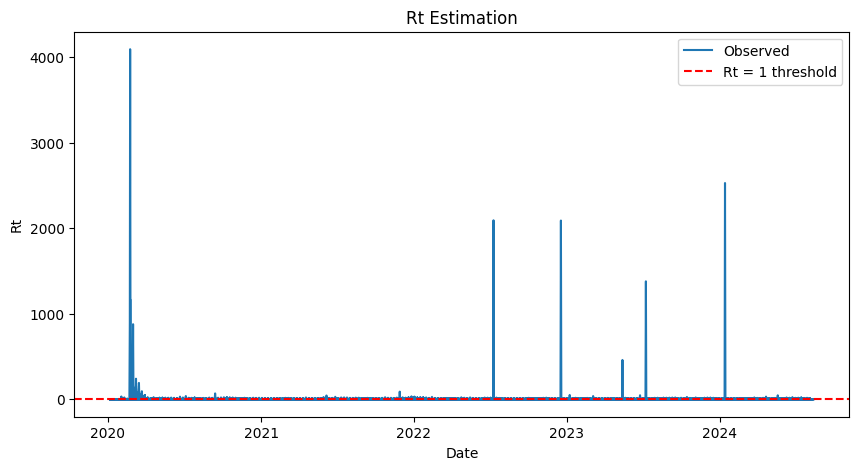

In [ ]:
df_reproduction_rate.to_excel('with_Rt_output.xlsx', index = False)

#Optional : Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_reproduction_rate['date'], df_reproduction_rate['reproduction_rate'], label='Observed')
plt.axhline(y=1, color='red', linestyle='--', label='Rt = 1 threshold')
plt.xlabel('Date')
plt.ylabel('Rt')
plt.title('Rt Estimation')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)

In [ ]:
missing_counts

,0
location,
Australia,39105
Canada,32340
Chile,34362
Czechia,24759
Italy,26030
Malaysia,26252
South Africa,32865


In [ ]:
missing_counts.sort_values()

,0
location,
Czechia,24759
Italy,26030
Malaysia,26252
Canada,32340
South Africa,32865
Chile,34362
Australia,39105


   new_cases  hosp_patients  hosp_patients_per_million  \
0        0.0            NaN                        NaN   
1        0.0            NaN                        NaN   
2        0.0            NaN                        NaN   
3        0.0            NaN                        NaN   
4        0.0            NaN                        NaN   

   weekly_hosp_admissions  reproduction_rate  
0                     NaN                NaN  
1                     NaN                NaN  
2                     NaN                NaN  
3                     NaN                NaN  
4                     NaN                NaN  
R² Score: 0.4697337781322778
y_test shape: (2348,)
y_pred shape: (2348,)


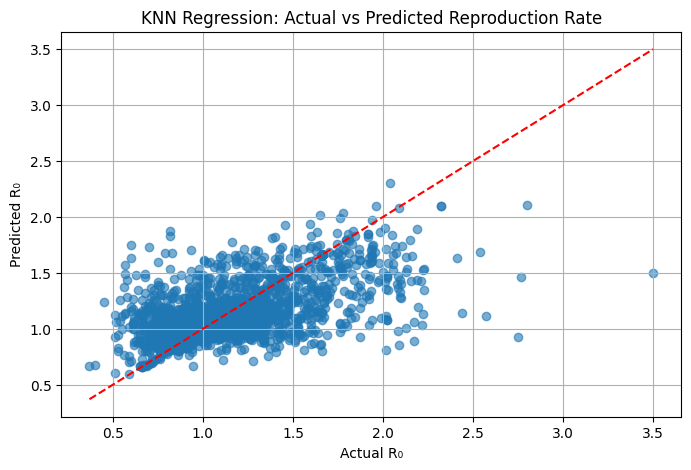

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------------------------
# 1. Load your dataset
# -----------------------------------------------
# Replace with your actual data source
df = pd.read_excel('/content/drive/MyDrive/owid-covid-data_Filtered.xlsx')

# Example: Preview data
print(df[["new_cases", "hosp_patients", "hosp_patients_per_million",
          "weekly_hosp_admissions", "reproduction_rate"]].head())

# -----------------------------------------------
# 2. Select Features & Target
# -----------------------------------------------
features = ["new_cases", "hosp_patients", "hosp_patients_per_million", "weekly_hosp_admissions"]
target = "reproduction_rate"

# Subset the data
data = df[features + [target]]

# -----------------------------------------------
# 3. Impute Missing Values (KNNImputer)
# -----------------------------------------------
# KNNImputer fills missing values using similar rows (neighbors)
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# -----------------------------------------------
# 4. Normalize Features
# -----------------------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(data_imputed[features])
y = data_imputed[target]

# -----------------------------------------------
# 5. Train/Test Split
# -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------------------------
# 6. Train KNN Regressor
# -----------------------------------------------
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# -----------------------------------------------
# 7. Evaluation
# -----------------------------------------------
print("R² Score:", r2_score(y_test, y_pred))
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

# -----------------------------------------------
# 8. Optional: Plot Actual vs Predicted
# -----------------------------------------------
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual R₀")
plt.ylabel("Predicted R₀")
plt.title("KNN Regression: Actual vs Predicted Reproduction Rate")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Reset index before splitting
data_imputed = data_imputed.reset_index(drop=True)

# Split again with return_index=True
from sklearn.model_selection import train_test_split
X = data_imputed[features]
y = data_imputed["reproduction_rate"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get indices of test set
test_indices = X_test.index

# Add predictions back
data_imputed.loc[test_indices, "predicted_R0"] = y_pred


In [ ]:
# OR: Save the full imputed dataset with predictions
data_imputed.to_excel("predicted_R0_full_dataset.xlsx", index=False)


In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load your Excel file
df = pd.read_excel("/content/owid-covid-data_latest_update.xlsx")

# Columns to use for imputation (adjusted for usefulness and availability)
features = [
    'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
    'total_cases_per_million', 'new_cases_per_million',
    'hosp_patients', 'hosp_patients_per_million', 'weekly_hosp_admissions',
    'weekly_hosp_admissions_per_million', 'stringency_index',
    'population_density', 'median_age', 'gdp_per_capita',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index', 'population',
    'reproduction_rate', 'icu_patients_per_million'
]

# Subset and apply imputer
df_impute = df[features].copy()
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df_impute)

# Replace only the missing values
df_imputed = pd.DataFrame(imputed, columns=features)
df['icu_patients_per_million'] = df['icu_patients_per_million'].combine_first(df_imputed['icu_patients_per_million'])

# Save to Excel
df.to_excel("owid-covid-data_with_latest_update.xlsx", index=False)
print("✅ Saved to 'owid-covid-data_with_latest_update.xlsx'")


FileNotFoundError: [Errno 2] No such file or directory: '/content/owid-covid-data_latest_update.xlsx'

In [ ]:
import matplotlib.pyplot as plt

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']

plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients_per_million'], color ='Yellow', label='South Africa')
plt.plot(df_Malaysia['date'], df_Malaysia['icu_patients_per_million'], color ='Green', label='Malaysia')
plt.plot(df_Czechia['date'], df_Czechia['icu_patients_per_million'], color ='Blue', label='Czechia')
plt.plot(df_Australia['date'], df_Australia['icu_patients_per_million'], color ='Red', label='Australia')
plt.plot(df_Canada['date'], df_Canada['icu_patients_per_million'], color ='Black', label='Canada')
plt.plot(df_Chile['date'], df_Chile['icu_patients_per_million'], color = 'orange', label='Chile')

plt.xlabel('Date')
plt.ylabel('ICU Patients per Million')
plt.title('ICU Patients per Million over Time by Location')
plt.legend()
plt.show()

In [ ]:
missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients'])

In [ ]:
import matplotlib.pyplot as plt

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']

plt.plot(df_SouthAfrica['date'], df_SouthAfrica['icu_patients'], color ='Yellow', label='South Africa')
plt.plot(df_Malaysia['date'], df_Malaysia['icu_patients'], color ='Green', label='Malaysia')
plt.plot(df_Czechia['date'], df_Czechia['icu_patients'], color ='Blue', label='Czechia')
plt.plot(df_Australia['date'], df_Australia['icu_patients'], color ='Red', label='Australia')
plt.plot(df_Canada['date'], df_Canada['icu_patients'], color ='Black', label='Canada')
plt.plot(df_Chile['date'], df_Chile['icu_patients'], color = 'orange', label='Chile')

plt.xlabel('Date')
plt.ylabel('ICU Patients per Million')
plt.title('ICU Patients per Million over Time by Location')
plt.legend()
plt.show()

In [ ]:
# Impute ICU patients in the dataset
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.impute import KNNImputer # Import KNNImputer

# Load the dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# Drop non-numeric columns
df = df.select_dtypes(include=['number'])

# Choose features that may help predict ICU admissions
features = [
    'new_cases', 'new_deaths', 'hosp_patients', 'weekly_hosp_admissions',
    'reproduction_rate', 'stringency_index', 'population', 'population_density',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'median_age', 'gdp_per_capita'
]

# Keep only available columns
features = [col for col in features if col in df.columns and col != 'icu_patients']

# Split rows with and without ICU data
df_known = df[df['icu_patients'].notna()].copy()
df_missing = df[df['icu_patients'].isna()].copy()

# Remove rows with missing values in features for training
df_known = df_known.dropna(subset=features)

#Train regression model
X_train = df_known[features]
y_train = df_known['icu_patients']
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate performance
X_test = df_known[features]
y_test = df_known['icu_patients']
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, model.predict(X_test)))

print(f"✅ Model trained. RMSE on known data: {rmse:.2f} ICU patients")

#Predict and impute missing ICU values in df_missing
X_missing = df_missing[features]

# Impute missing values in X_missing
imputer = KNNImputer(n_neighbors=5)
X_missing_imputed = imputer.fit_transform(X_missing)
X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=features, index=X_missing.index)


# Predict on the imputed missing data
predicted_icu = model.predict(X_missing_imputed_df)

# Impute the 'icu_patients' column in the original DataFrame
df.loc[df['icu_patients'].isna(), 'icu_patients'] = predicted_icu


# Save to Excel
df.to_excel("owid-covid-data_with_icu_imputed.xlsx", index=False)
print("✅ File saved as 'owid-covid-data_with_icu_imputed.xlsx'")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 1. Drop all string and datetime columns to retain only usable numeric features
df_numeric = df.select_dtypes(include=[np.number]).copy()

# 2. Identify rows with and without ICU patient values
df_with_icu = df_numeric[df_numeric['icu_patients'].notna()]
df_missing_icu = df_numeric[df_numeric['icu_patients'].isna()]

# 3. Select features (exclude target column)
features = df_numeric.columns.drop('icu_patients')

# 4. Impute missing feature values
imputer = SimpleImputer(strategy="mean")
X_full = imputer.fit_transform(df_with_icu[features])
y_full = df_with_icu['icu_patients']

# 5. Train a fast, accurate model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_full, y_full)

# 6. Predict missing ICU patients
X_missing = imputer.transform(df_missing_icu[features])
icu_predicted = model.predict(X_missing)

# 7. Ensure predictions are non-negative integers
icu_predicted = np.maximum(icu_predicted, 0)  # eliminate negatives
icu_predicted = np.round(icu_predicted).astype(int)  # round to integers

# 8. Fill back into original dataframe
df.loc[df['icu_patients'].isna(), 'icu_patients'] = icu_predicted

# 9. Save to Excel
df.to_excel("owid-covid-data_with_icu_predictions.xlsx", index=False)
print("✅ Saved updated file: 'owid-covid-data_with_icu_predictions.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

# Load your dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 1. Convert date column to datetime if not already
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2. Add numeric date (for trend modeling)
df['date_ordinal'] = df['date'].map(datetime.toordinal)

# 3. Drop non-numeric columns except 'location' (we'll handle it separately)
keep_cols = df.select_dtypes(include=[np.number]).columns.tolist() + ['location']
df = df[keep_cols]

# 4. Track final predictions for merging
df['icu_predicted'] = df['icu_patients']

# 5. Prepare a loop per country
countries = df['location'].dropna().unique()

for country in countries:
    sub_df = df[df['location'] == country]

    # Must have some known ICU data to train
    if sub_df['icu_patients'].notna().sum() < 10:
        continue

    # Features (drop ICU, include date_ordinal)
    features = sub_df.columns.drop(['icu_patients', 'icu_predicted', 'location'])
    df_train = sub_df[sub_df['icu_patients'].notna()]
    df_missing = sub_df[sub_df['icu_patients'].isna()]

    if df_missing.empty:
        continue

    # Impute missing feature values
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(df_train[features])
    y_train = df_train['icu_patients']
    X_missing = imputer.transform(df_missing[features])

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_missing)
    y_pred = np.maximum(y_pred, 0)  # No negatives
    y_pred = np.round(y_pred).astype(int)

    # Fill into main df
    df.loc[(df['location'] == country) & (df['icu_patients'].isna()), 'icu_predicted'] = y_pred

# 6. Replace original ICU column with predicted where missing
df['icu_patients'] = df['icu_patients'].combine_first(df['icu_predicted'])
df = df.drop(columns=['icu_predicted'])

# 7. Save to Excel
df.to_excel("owid-covid-data_with_icu_predictions_realistic.xlsx", index=False)
print("✅ Saved: 'owid-covid-data_with_icu_predictions_realistic.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

# Load the dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# Convert 'date' column to datetime
if df['date'].dtype == object:
    df['date'] = pd.to_datetime(df['date'])

# Drop string and object columns except 'location' and 'date'
drop_cols = df.select_dtypes(include=['object', 'string']).columns.difference(['location', 'date'])
df = df.drop(columns=drop_cols)

# Define features (all numeric except icu_patients and identifiers)
features = df.select_dtypes(include=[np.number]).columns.difference(['icu_patients']).tolist()

# Prepare for imputation
df = df.sort_values(['location', 'date'])
df['icu_patients_imputed'] = df['icu_patients']

# Initialize model
model = HistGradientBoostingRegressor(random_state=42)

# Track countries skipped
skipped_countries = []
successful_countries = []

# Iterate per country
for country in df['location'].unique():
    country_df = df[df['location'] == country].copy()

    known = country_df[country_df['icu_patients'].notna()]
    unknown = country_df[country_df['icu_patients'].isna()]

    if len(known) < 5 or len(unknown) == 0:
        skipped_countries.append(country)
        continue

    # Prepare training data
    X_train = known[features].dropna()
    y_train = known.loc[X_train.index, 'icu_patients']

    if X_train.empty:
        skipped_countries.append(country)
        continue

    # Train model
    model.fit(X_train, y_train)

    # Predict on unknown rows that have no NaNs
    X_pred = unknown[features].dropna()

    if X_pred.empty:
        skipped_countries.append(country)
        continue

    y_pred = model.predict(X_pred)
    y_pred = np.round(np.clip(y_pred, 0, None)).astype(int)

    # Impute values
    df.loc[X_pred.index, 'icu_patients_imputed'] = y_pred
    successful_countries.append(country)

# Finalize: replace original column
df['icu_patients'] = df['icu_patients'].combine_first(df['icu_patients_imputed'])
df.drop(columns='icu_patients_imputed', inplace=True)

# Save output
df.to_excel("owid-covid-data_with_icu_patients_imputed.xlsx", index=False)

# Output status
print("✅ Done. File saved as: 'owid-covid-data_with_icu_patients_imputed.xlsx'")
print(f"✅ Countries successfully predicted: {len(successful_countries)}")
print(f"⚠️ Countries skipped due to data issues: {skipped_countries}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

# 1. Load dataset
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 2. Convert date column if necessary
if df['date'].dtype == 'O':
    df['date'] = pd.to_datetime(df['date'])

# 3. Add time progression feature
df['days_since_first_entry'] = df.groupby('location')['date'].transform(lambda x: (x - x.min()).dt.days)

# 4. Drop columns with non-numeric types (excluding 'location' for encoding)
df_numeric = df.copy()
non_numeric_cols = df_numeric.select_dtypes(include=['object', 'datetime']).columns.tolist()
non_numeric_cols = [col for col in non_numeric_cols if col != 'location']
df_numeric.drop(columns=non_numeric_cols, inplace=True)

# 5. Encode 'location'
encoder = OrdinalEncoder()
df_numeric['location'] = encoder.fit_transform(df[['location']])

# 6. Define features and target
features = df_numeric.columns.drop('icu_patients')
target = 'icu_patients'

# 7. Split into known and missing ICU data
df_known = df_numeric[df_numeric['icu_patients'].notna()]
df_missing = df_numeric[df_numeric['icu_patients'].isna()]

# 8. Train model
X = df_known[features]
y = df_known[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor(max_iter=500)
model.fit(X_train, y_train)

# 9. Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 10. Predict and round ICU patients
X_missing = df_missing[features]
icu_pred = model.predict(X_missing)
icu_pred = np.maximum(np.round(icu_pred), 0)  # no negatives

# 11. Impute predicted values into original df
df.loc[df['icu_patients'].isna(), 'icu_patients'] = icu_pred

# 12. Save result
df.to_excel("owid-covid-data_with_icu_imputed.xlsx", index=False)
print("✅ File saved as 'owid-covid-data_with_icu_imputed.xlsx'")


In [ ]:
missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from datetime import timedelta

# 1. Load data
df = pd.read_excel("/content/owid-covid-data_with_latest_update.xlsx")

# 2. Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# 3. Sort and create lag features
df = df.sort_values(['location', 'date'])
for lag in [1, 3, 7]:
    df[f'new_cases_lag_{lag}'] = df.groupby('location')['new_cases'].shift(lag)
    df[f'new_deaths_lag_{lag}'] = df.groupby('location')['new_deaths'].shift(lag)
    df[f'hosp_patients_lag_{lag}'] = df.groupby('location')['hosp_patients'].shift(lag)

# 4. Derived feature: days since first case
df['days_since_first_case'] = df.groupby('location')['new_cases'].cumsum().gt(0).groupby(df['location']).cumsum()

# 5. Filter where ICU data is known
target = 'icu_patients'
features = [
    'new_cases', 'new_deaths', 'total_cases', 'total_deaths',
    'hosp_patients', 'population', 'stringency_index',
    'population_density', 'median_age', 'gdp_per_capita',
    'diabetes_prevalence', 'hospital_beds_per_thousand',
    'life_expectancy', 'human_development_index', 'days_since_first_case',
    'new_cases_lag_1', 'new_cases_lag_3', 'new_cases_lag_7',
    'new_deaths_lag_1', 'new_deaths_lag_3', 'new_deaths_lag_7',
    'hosp_patients_lag_1', 'hosp_patients_lag_3', 'hosp_patients_lag_7'
]

# Remove rows with missing values in features or target
train_df = df[df[target].notna()].dropna(subset=features)

# 6. Split and train model
X = train_df[features]
y = train_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 7. Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 8. Predict missing ICU values
missing_mask = df[target].isna()
X_missing = df.loc[missing_mask, features].copy()
X_missing = X_missing.dropna()

preds = model.predict(X_missing)
preds = np.round(np.maximum(preds, 0)).astype(int)  # Ensure realistic ICU values

# Insert predictions
df.loc[X_missing.index, target] = preds

# 9. Save to Excel
df.to_excel("owid-covid-data_imputed_icu.xlsx", index=False)
print("✅ Final dataset saved to 'owid-covid-data_imputed_icu.xlsx'")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer # Import SimpleImputer

# 1. Load your filtered dataset
df = pd.read_excel('/content/owid-covid-data_with_latest_update.xlsx')

# 2. Ensure date and sorting
df['date'] = pd.to_datetime(df['date'])
df.sort_values(['location', 'date'], inplace=True)

# 3. Time progression
df['days_since_start'] = df.groupby('location')['date'].transform(lambda x: (x - x.min()).dt.days)

# 4. Lag features
df['new_cases_lag1'] = df.groupby('location')['new_cases'].shift(1)
df['new_deaths_lag1'] = df.groupby('location')['new_deaths'].shift(1)

# 5. Epidemiological logic flag
df['epidemic_inactive'] = ((df['total_cases'].fillna(0) == 0) & (df['total_deaths'].fillna(0) == 0)).astype(int)

# 6. Keep only numeric features
numeric_df = df.select_dtypes(include=[np.number]).copy()

# 7. Define target and drop it from features
target = 'icu_patients'
available_features = numeric_df.columns.drop(target)

# 8. Prepare training data
df_train = df[df[target].notna()].copy()

# Impute missing values in training features
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(df_train[available_features])
y = df_train[target]

# 9. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 10. Train model
model = GradientBoostingRegressor(n_estimators=400, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 11. Evaluate model
y_pred = model.predict(X_test)

print(f"✅ Model trained. RMSE: {rmse:.2f} ICU patients")

# 12. Impute missing values in the prediction set as well
missing_mask = df['icu_patients'].isna()
X_missing = df.loc[missing_mask, available_features].copy()

# Impute missing values in the prediction features
X_missing_imputed = imputer.transform(X_missing)


icu_pred = model.predict(X_missing_imputed)

# 13. Apply epidemiological logic
# Ensure X_missing_imputed has the same index as the original df for alignment
X_missing_imputed_df = pd.DataFrame(X_missing_imputed, columns=available_features, index=X_missing.index)

icu_pred[(X_missing_imputed_df['epidemic_inactive'] == 1) | (X_missing_imputed_df['new_cases'] == 0)] = 0
icu_pred = np.round(np.maximum(icu_pred, 0)).astype(int)


# 14. Fill in predictions
df.loc[X_missing_imputed_df.index, 'icu_patients'] = icu_pred

# 15. Save result

df.to_excel('owid-covid-data_with_icu_imputed.xlsx', index=False)

In [ ]:
df=pd.read_excel('/content/owid-covid-data_with_latest_update_2.xlsx')

missing_counts = df.isna().groupby(df['location']).sum().sum(axis=1)
missing_counts.sort_values()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_excel('/content/owid-covid-data_with_latest_update_2.xlsx')

df_SouthAfrica = df[df['location']=='South Africa']
df_Malaysia = df[df['location']=='Malaysia']
df_Czechia = df[df['location']=='Czechia']
df_Australia = df[df['location']=='Australia']
df_Canada = df[df['location']=='Canada']
df_Chile = df[df['location']=='Chile']


In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases'], linestyle = "-", label = 'Number of new cases')


plt.xlabel('Year')
plt.ylabel('Number of new cases')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases_smoothed'], label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Malaysia')
plt.legend()
plt.show()

This is EDA on Czechia to do feature selection


In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases'], linestyle = "-", label = 'New Cases')


plt.xlabel('Year')
plt.ylabel('New cases')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases_smoothed'], linestyle = "-", label = 'New Cases Smoothed')


plt.xlabel('Year')
plt.ylabel('New cases Smoothed')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['total_cases'], linestyle = "-", label = 'Total Cases')


plt.xlabel('Year')
plt.ylabel('Total cases')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Czechia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Canada')
plt.legend()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths'], linestyle = "-", label = 'New Deaths')


plt.xlabel('Year')
plt.ylabel('New Deaths')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths_smoothed'], linestyle = "-", label = 'New Deaths Smoothed')


plt.xlabel('Year')
plt.ylabel('New Deaths Smoothed')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['total_deaths'], linestyle = "-", label = 'Total Deaths')


plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_SouthAfrica['date'], df_SouthAfrica['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('South Africa')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Malaysia['date'], df_Malaysia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Malaysia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Czechia')
plt.legend()

In [ ]:
plt.plot(df_Czechia['date'], df_Czechia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Czechia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Australia')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Australia['date'], df_Australia['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Australia')
plt.legend()
plt.show()


In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Canada['date'], df_Canada['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Canada')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_cases_per_million'], linestyle = "-", label = 'New Cases per Million')


plt.xlabel('Year')
plt.ylabel('New Cases per Million')
plt.title('Chile')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_Chile['date'], df_Chile['new_deaths_per_million'], linestyle = "-", label = 'New Deaths per Million')


plt.xlabel('Year')
plt.ylabel('New Deaths per Million')
plt.title('Chile')
plt.legend()
plt.show()